# Generate a model from scratch

In [1]:
from set_up_grasp_models.set_up_models.set_up_model import set_up_model
import os

Fragments already downloaded


Exporting file 2 of 2 [00:00]: compounds.sqlite


Fragments already downloaded


In [2]:
# file with model reactions
file_in_stoic = os.path.join('example_files', 'glycolysis_example.txt')
# GRASP input file with general sheet
base_excel_file = os.path.join('..', 'base_files', 'GRASP_general.xlsx')

# define model name
model_name = 'glycolysis_v1'
# define output file
file_out = os.path.join('example_files', 'output', model_name + '.xlsx')

# generate model
set_up_model(model_name, file_in_stoic, base_excel_file, file_out)

### Optionally fill in Gibbs energies

In [3]:
# file with model reactions
file_in_stoic = os.path.join('example_files', 'glycolysis_example.txt')
# GRASP input file with general sheet
base_excel_file = os.path.join('..', 'base_files', 'GRASP_general.xlsx')

# define model name
model_name = 'glycolysis_v1_gibbs'
# define output file
file_out = os.path.join('example_files', 'output', model_name + '.xlsx')

# generate model
set_up_model(model_name, file_in_stoic, base_excel_file, file_out, use_equilibrator=True)

### Optionally provide metabolomics data

In [4]:
# file with model reactions
file_in_stoic = os.path.join('example_files', 'glycolysis_example.txt')
# GRASP input file with general sheet
base_excel_file = os.path.join('..', 'base_files', 'GRASP_general.xlsx')

# define metabolomics input file
file_in_mets_conc = os.path.join('example_files', 'met_concs.xlsx')

# define model name
model_name = 'glycolysis_v1_gibbs_metabolomics'
# define output file
file_out = os.path.join('example_files', 'output', model_name + '.xlsx')

# generate model
set_up_model(model_name, file_in_stoic, base_excel_file, file_out, use_equilibrator=True,
             file_in_mets_conc=file_in_mets_conc)

### Generate GRASP mechanism patterns from elementary reactions

In [5]:
from set_up_grasp_models.set_up_models.convert_mechanisms import generate_mechanisms

In [6]:
# define model name
model_name = 'glycolysis_v2'
# define input file
file_in_model = os.path.join('example_files', 'output', model_name + '.xlsx')

# define path to folder with elementary reaction mechanisms
mech_in_dir = os.path.join('example_files', 'mechanisms')

# define path to folder where the pattern files will be generated
pattern_out_dir = os.path.join('/home', 'mrama', 'GRASP_test', 'GRASP', 'patterns')

generate_mechanisms(file_in_model, mech_in_dir, pattern_out_dir)

# Generate a modified version of an existing model

In [7]:
# file with model reactions
file_in_stoic = os.path.join('example_files', 'glycolysis_example.txt')
# GRASP input file with general sheet
base_excel_file = os.path.join('example_files', 'model_v2.3.xlsx')

# define metabolomics input file
file_in_mets_conc = os.path.join('example_files', 'met_concs.xlsx')

# define model name
model_name = 'glycolysis_v3'
# define output file
file_out = os.path.join('example_files', 'output', model_name + '.xlsx')

# generate model
set_up_model(model_name, file_in_stoic, base_excel_file, file_out)

# Check models for consistency

In [8]:
from set_up_grasp_models.check_models.format_checks import check_met_rxn_order, check_kinetics_met_separators, \
    check_kinetics_subs_prod_order, check_rxn_mechanism_order
from set_up_grasp_models.check_models.thermodynamics_checks import check_thermodynamic_feasibility
from set_up_grasp_models.check_models.mass_balance_checks import check_flux_balance, check_balanced_metabolites

import pandas as pd

In [9]:
model_name = 'glycolysis_v3'
file_in = os.path.join('example_files', 'output', model_name + '.xlsx')
data_dict = pd.read_excel(file_in, sheet_name=None, index_col=0)


# check if the order of metabolites and reactions in all excel sheets is consistent
check_met_rxn_order(data_dict)

# check metabolite lists separators in kinetics sheet
check_kinetics_met_separators(data_dict)

# checks if metabolite names in subtrate/product order columns are indeed substrates/products of the respective reaction
check_kinetics_subs_prod_order(data_dict)

# checks if massAction/diffusion/freeExchange mechanism come after other enzyme mechanisms and fixedExchange comes at the end
check_rxn_mechanism_order(data_dict)


# check if fluxes and Gibbs energies are compatible
check_thermodynamic_feasibility(data_dict)

# check consistency between stoic sheet and mets sheet, take the results with a grain of salt, there are false positives
check_balanced_metabolites(data_dict)


# check if all metabolites marked as balanced are indeed mass balance, only works if fluxes for all reactions are
# either specified or can be calculated
check_flux_balance(data_dict)


Checking if the order of reactions and metabolites is the same in all excel sheets.

Everything seems to be OK.


Checking if values are separated by a space in the kinetics sheet in columns order, promiscuous, inhibitors, activators, negative effector, and positive effector.
It looks for dots, commas, and semi-colons.

Everything seems to be OK.


Checking if the metabolite names in the substrate and product order columns in the kinetics sheet are valid, i.e., if they are indeed substrates and products of the respective reaction.

The following metabolites in the substrate order column for reaction R_G6PDH2_NADP are not part of the reaction substrates:
{'m_nad_c'}

The following metabolites in the product order column for reaction R_G6PDH2_NADP are not part of the reaction products:
{'m_nadh_c'}

The following metabolites in the substrate order column for reaction R_G6PDH2_NAD are not part of the reaction substrates:
{'m_nadp_c'}

The following metabolites in the product order column

True

## Visualize thermodynamic consistency

In [10]:
import altair as alt

#### Define function for visualization

In [11]:
def plot_dG_and_flux(dG_df, flux_df, height=400, width=600):
    threshold_df = pd.DataFrame([{"ThresholdValue": 0, "Threshold": "hazardous"}])
    
    rect_dG = alt.Chart(dG_df).mark_rect().encode(
        y ='rxn:N',
        x='∆G_min',
        x2='∆G_max'
    ).properties(
        height=height,
        width=width
    )

    point_dG = alt.Chart(dG_df).mark_point(size=100, color='red', filled=True).encode(
        y ='rxn:N',
        x='∆G_mean',
        tooltip=['rxn', '∆G_min', '∆G_mean', '∆G_max']
    ).interactive()


    rule_dG = alt.Chart(threshold_df).mark_rule().encode(
        x='ThresholdValue:Q'
    )


    rect_flux = alt.Chart(flux_df).mark_rect().encode(
        y ='rxn:N',
        x='flux_min:Q',
        x2='flux_max:Q'
    ).properties(
        height=height,
        width=width
    )

    point_flux = alt.Chart(flux_df).mark_point(size=100, color='red', filled=True).encode(
        y ='rxn:N',
        x='flux',
        tooltip=['rxn', 'flux_min', 'flux', 'flux_max']
    ).interactive()


    rule_flux = alt.Chart(threshold_df).mark_rule().encode(
        x='ThresholdValue:Q'
    )

    return alt.hconcat(rect_dG + point_dG + rule_dG, rect_flux + point_flux + rule_flux)

In [12]:
# Get flux and Gibbs energies info from check_thermodynamic_feasibility
flag, flux_df, dG_df = check_thermodynamic_feasibility(data_dict) 

# Modify dataframes
dG_df['rxn'] = dG_df.index

flux_df['rxn'] = flux_df.index
flux_df['flux_min'] = flux_df['MBo10_mean'] - flux_df['MBo10_std']
flux_df['flux_max'] = flux_df['MBo10_mean'] + flux_df['MBo10_std']
flux_df['flux'] = flux_df['MBo10_mean']


Checking if fluxes and Gibbs energies are compatible.

The flux and ∆G range seem to be incompatible for reaction R_PGI
The flux and ∆G range seem to be incompatible for reaction R_ENO


/home/mrama/miniconda3/envs/grasp_models/lib/python3.7/site-packages/altair/utils/core.py:284: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


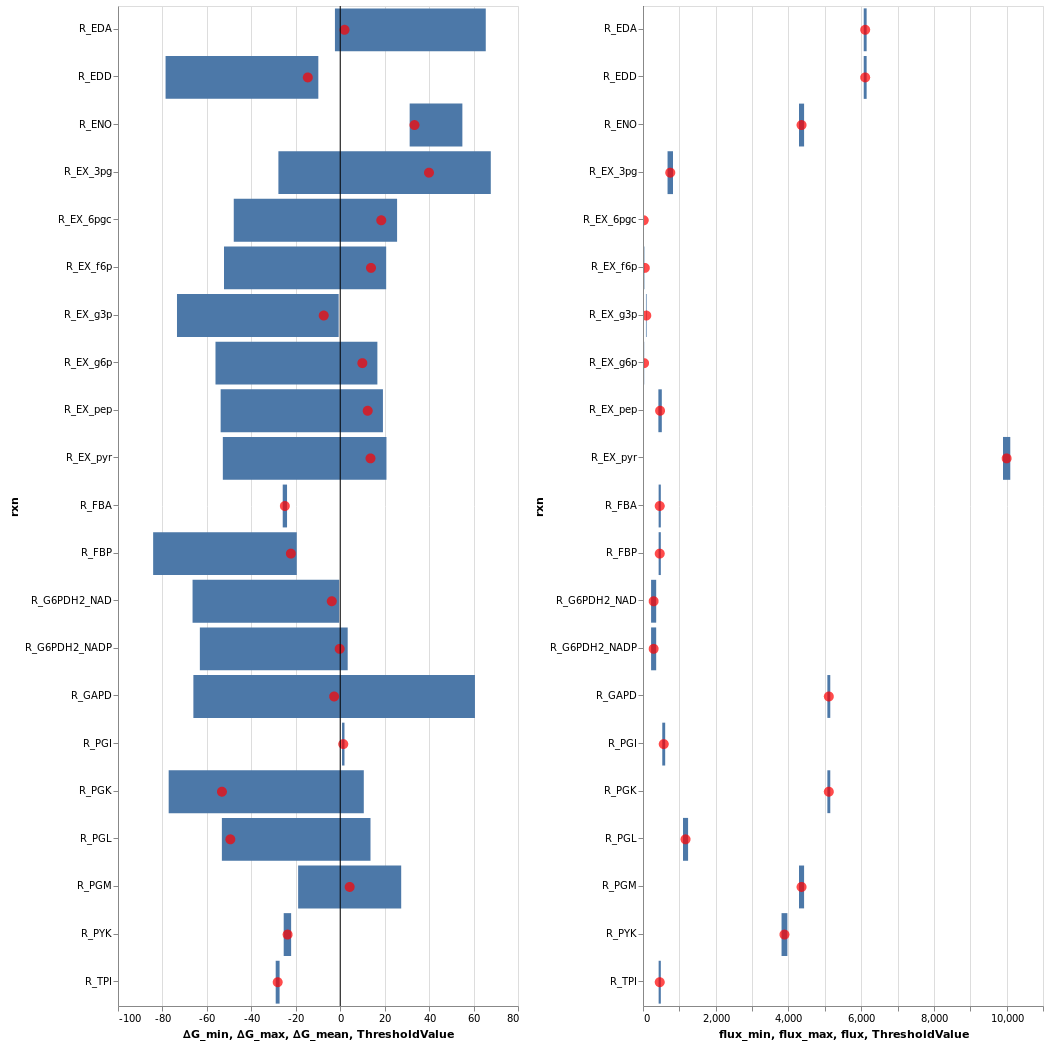

In [13]:
# Plot reactions fluxes and respective Gibbs energies
height=1000
width=400
plot_dG_and_flux(dG_df,  flux_df, height, width)

# Misc

### Reorder reactions in the model

In [14]:
from set_up_grasp_models.set_up_models.manipulate_model import remove_spaces, reorder_reactions, rename_columns

In [15]:
# list with reaction order
rxn_order = ['R_PGL', 'R_EDD', 'R_EDA', 'R_PGI', 'R_FBP', 'R_FBA', 'R_TPI', 'R_GAPD',
             'R_PGK', 'R_PGM', 'R_ENO', 'R_PYK', 'R_G6PDH2','R_EX_pyr', 'R_EX_pep', 
             'R_EX_g6p', 'R_EX_6pgc', 'R_EX_g3p', 'R_EX_f6p', 'R_EX_3pg']

# path to current model
model_name = 'glycolysis_v2'
file_in = os.path.join('example_files', 'output', model_name + '.xlsx')

# import current model with pandas
data_dict = pd.read_excel(file_in, sheet_name=None, index_col=0)

# path to the model with re-ordered reactions - just substitute current one
file_out = file_in

# re-order reactions according to rxn_list
reorder_reactions(data_dict, rxn_order, file_out)

### Rename columns in the model

In [16]:
# path to current model
model_name = 'glycolysis_v2'
file_in = os.path.join('example_files', 'output', model_name + '.xlsx')

# import current model with pandas
data_dict = pd.read_excel(file_in, sheet_name=None, index_col=0)

# path to the model with re-ordered reactions - just substitute current one
file_out = file_in

# renames columns names, so that they are standard and cause no problems with other functions
rename_columns(data_dict, file_out)

### Remove all leading and trailing spaces in all string cells

In [17]:
# path to current model
model_name = 'glycolysis_v2'
file_in = os.path.join('example_files', 'output', model_name + '.xlsx')

# import current model with pandas
data_dict = pd.read_excel(file_in, sheet_name=None, index_col=0)

# path to the model with re-ordered reactions - just substitute current one
file_out = file_in

# remove any leading or trailing spaces in all string cells
remove_spaces(data_dict, file_out)

### Get .m file to simulate model

In [18]:
from set_up_grasp_models.set_up_models.set_up_ode_model import convert_to_ode_model

In [19]:
model_name = 'glycolysis_v2'
file_in = os.path.join('example_files', 'output', model_name + '_Kinetics1.m')

convert_to_ode_model(file_in)